In [315]:
import pandas as pd

In [316]:
df = pd.read_csv('BTC_Trial_NB.csv')

In [317]:
df.index = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

,Date,Month,Year,VOL1,VOL7,VOL30,ClosePrice,OpenPrice,HighPrice,LowPrice,...,SP500,RUSSELL,Oil,Gold,Silver,USDEUR,USDYUAN,Interest Rate,Economic Uncertainty,Crypto Index
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-04,04/02/2018,2,2018,0.058984,0.104624,0.204218,8277.01,9175.70,9334.87,8031.22,...,2648.94,1491.09,64.18,1336.5,16.71,0.80,6.30,1.80,0.234505,30
2018-02-05,05/02/2018,2,2018,0.082982,0.130688,0.219808,6955.27,8270.54,8364.84,6756.68,...,2648.94,1491.09,64.18,1336.5,16.67,0.80,6.31,1.80,0.248054,15
2018-02-06,06/02/2018,2,2018,0.041061,0.134668,0.221316,7754.00,7051.75,7850.70,6048.26,...,2695.14,1507.17,63.48,1329.5,16.58,0.81,6.29,1.82,0.223228,40
2018-02-07,07/02/2018,2,2018,0.041213,0.136422,0.222866,7621.30,7755.49,8509.11,7236.79,...,2681.66,1507.97,61.91,1314.6,16.24,0.81,6.28,1.85,0.201785,24
2018-02-08,08/02/2018,2,2018,0.030796,0.130387,0.222486,8265.59,7637.86,8558.77,7637.86,...,2581.00,1463.79,61.30,1319.0,16.34,0.82,6.27,1.85,0.183604,11


In [318]:
df['Return'] = df['ClosePrice '].pct_change()
df = df.dropna()

In [319]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [320]:
df['Return'].head()

Date
2018-02-05   -0.159688
2018-02-06    0.114838
2018-02-07   -0.017114
2018-02-08    0.084538
2018-02-09    0.057030
Name: Return, dtype: float64

In [321]:
# Define the features and target variable
y = df['Return']

# Split the data into train and test sets
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

# Define and fit the GARCH-X model with scaled features
model = arch_model(y_train, vol='GARCH', p=2, q=3, o=2, mean='zero')
garch = model.fit(disp="off")

# Print summaries
print("GARCH-X Model Summary:")
print(garch.summary())

GARCH-X Model Summary:
                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                3537.30
Distribution:                  Normal   AIC:                          -7058.59
Method:            Maximum Likelihood   BIC:                          -7014.42
                                        No. Observations:                 1847
Date:                Sat, Aug 31 2024   Df Residuals:                     1847
Time:                        00:00:17   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8491e-04  1.098e-04

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [322]:
history = [x for x in y_train]

# make first prediction
predictions = list()
model = arch_model(history, vol='GARCH', p=2, q=3, o=2, mean='zero')
model_fit = model.fit(disp="off")
conditional_volatility = model_fit.conditional_volatility

forecast = model_fit.forecast()
forecast = np.sqrt(forecast.variance)
yhat = forecast.T
predictions.append(yhat.values)
history.append(y_test[0])

for i in range(1, len(y_test),1):
    # predict
    model = arch_model(history, vol='GARCH', p=2, q=3, o=2, mean='zero')
    model_fit = model.fit(disp="off")
    forecast = model_fit.forecast(horizon=1)
    forecast = np.sqrt(forecast.variance)
    yhat = forecast.T
    # invert transformed prediction
    predictions.append(yhat.values)
    # observation
    obs = y_test[i]
    history.append(obs)

flattened_predictions = [item for sublist in predictions for item in (sublist if isinstance(sublist, np.ndarray) else [sublist])]

print(flattened_predictions)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


C:\Users\DELL\AppData\Local\Temp\ipykernel_28788\2763420120.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(y_test[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0014. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_28788\2763420120.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

[array([0.03038159]), array([0.02910907]), array([0.03096105]), array([0.03027222]), array([0.02975727]), array([0.02942685]), array([0.03292156]), array([0.03232381]), array([0.02831736]), array([0.03202569]), array([0.03061514]), array([0.03044149]), array([0.04212445]), array([0.03198507]), array([0.03310372]), array([0.03918266]), array([0.04237267]), array([0.03370206]), array([0.03602581]), array([0.03788919]), array([0.04282522]), array([0.03709418]), array([0.03668184]), array([0.03680472]), array([0.03573086]), array([0.0368056]), array([0.03550021]), array([0.03569477]), array([0.03497934]), array([0.03357112]), array([0.03515464]), array([0.03203346]), array([0.03301159]), array([0.03311169]), array([0.03183273]), array([0.03061846]), array([0.03077469]), array([0.03068961]), array([0.02939256]), array([0.02903943]), array([0.02872594]), array([0.02819286]), array([0.02948746]), array([0.02806538]), array([0.03049]), array([0.0285648]), array([0.02845581]), array([0.02859408

C:\Users\DELL\AppData\Local\Temp\ipykernel_28788\2763420120.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = y_test[i]
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_28788\2763420120.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

In [323]:
len(flattened_predictions), len(y_test)

(462, 462)

In [324]:
flattened_predictions = flattened_predictions[1:]
y_test = y_test[:-1]

In [334]:
prediction_df = pd.DataFrame(flattened_predictions, columns=['Predictions'])
prediction_df = prediction_df - 0.021
prediction_df.index = y_test.index


In [326]:
# model2 = arch_model(y, vol='GARCH', p=1, q=1, o=0, mean='zero')
# model_fit2 = model2.fit(disp="off")
# conditional_volatility = model_fit2.conditional_volatility
# conditional_volatility_df = pd.DataFrame(conditional_volatility, columns=['conditional_volatility'])

In [327]:
conditional_volatility.shape, y.shape

((1847,), (2309,))

In [328]:
len(y_test)

461

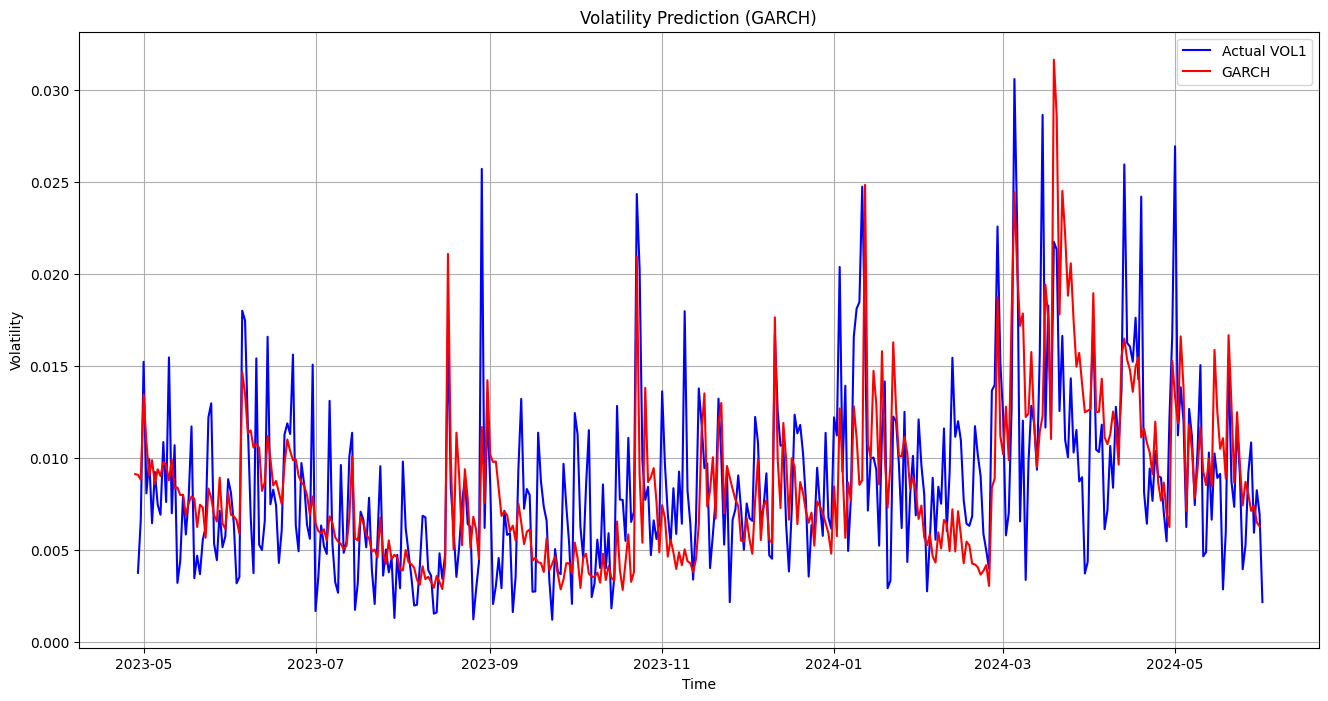

In [335]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
# plt.plot(y.index[-600:], y.tail(600), color='green', label = 'Train Stock Price')

p=400

# plt.plot(df.index[-600:], df['Return'].tail(600), color = 'grey', label = 'Realized Returns')
plt.plot(df.index[-p:], df['VOL1'].tail(p), color = 'blue', label = 'Actual VOL1')
plt.plot(y_test.index[-p:], prediction_df[-p:], color = 'red', label = 'GARCH')
plt.title('Volatility Prediction (GARCH)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [337]:
prediction_df.to_csv('GARCH.csv')

In [336]:
# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#NMSE
def nmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    variance = np.var(y_true)
    return mse / variance

#DA
def DA(y_true, y_pred):
    # Convert the arrays to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the direction of change
    true_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    
    # Compare directions
    correct_direction = np.sum(true_direction == pred_direction)
    total_direction = len(true_direction)
    
    # Calculate directional accuracy
    da = correct_direction / total_direction * 100
    
    return da

y_true = np.array(conditional_volatility[-len(prediction_df):])
y_predi = np.array(prediction_df).flatten() 

print("RMSE: ", rmse(y_true, y_predi))
print("MAPE: ", mape(y_true, y_predi))
print("NMSE: ", nmse(y_true, y_predi))
print("DA: ", DA(y_true, y_predi))

RMSE:  0.02765000302742817
MAPE:  72.95043990989411
NMSE:  13.663105586177055
DA:  56.95652173913044


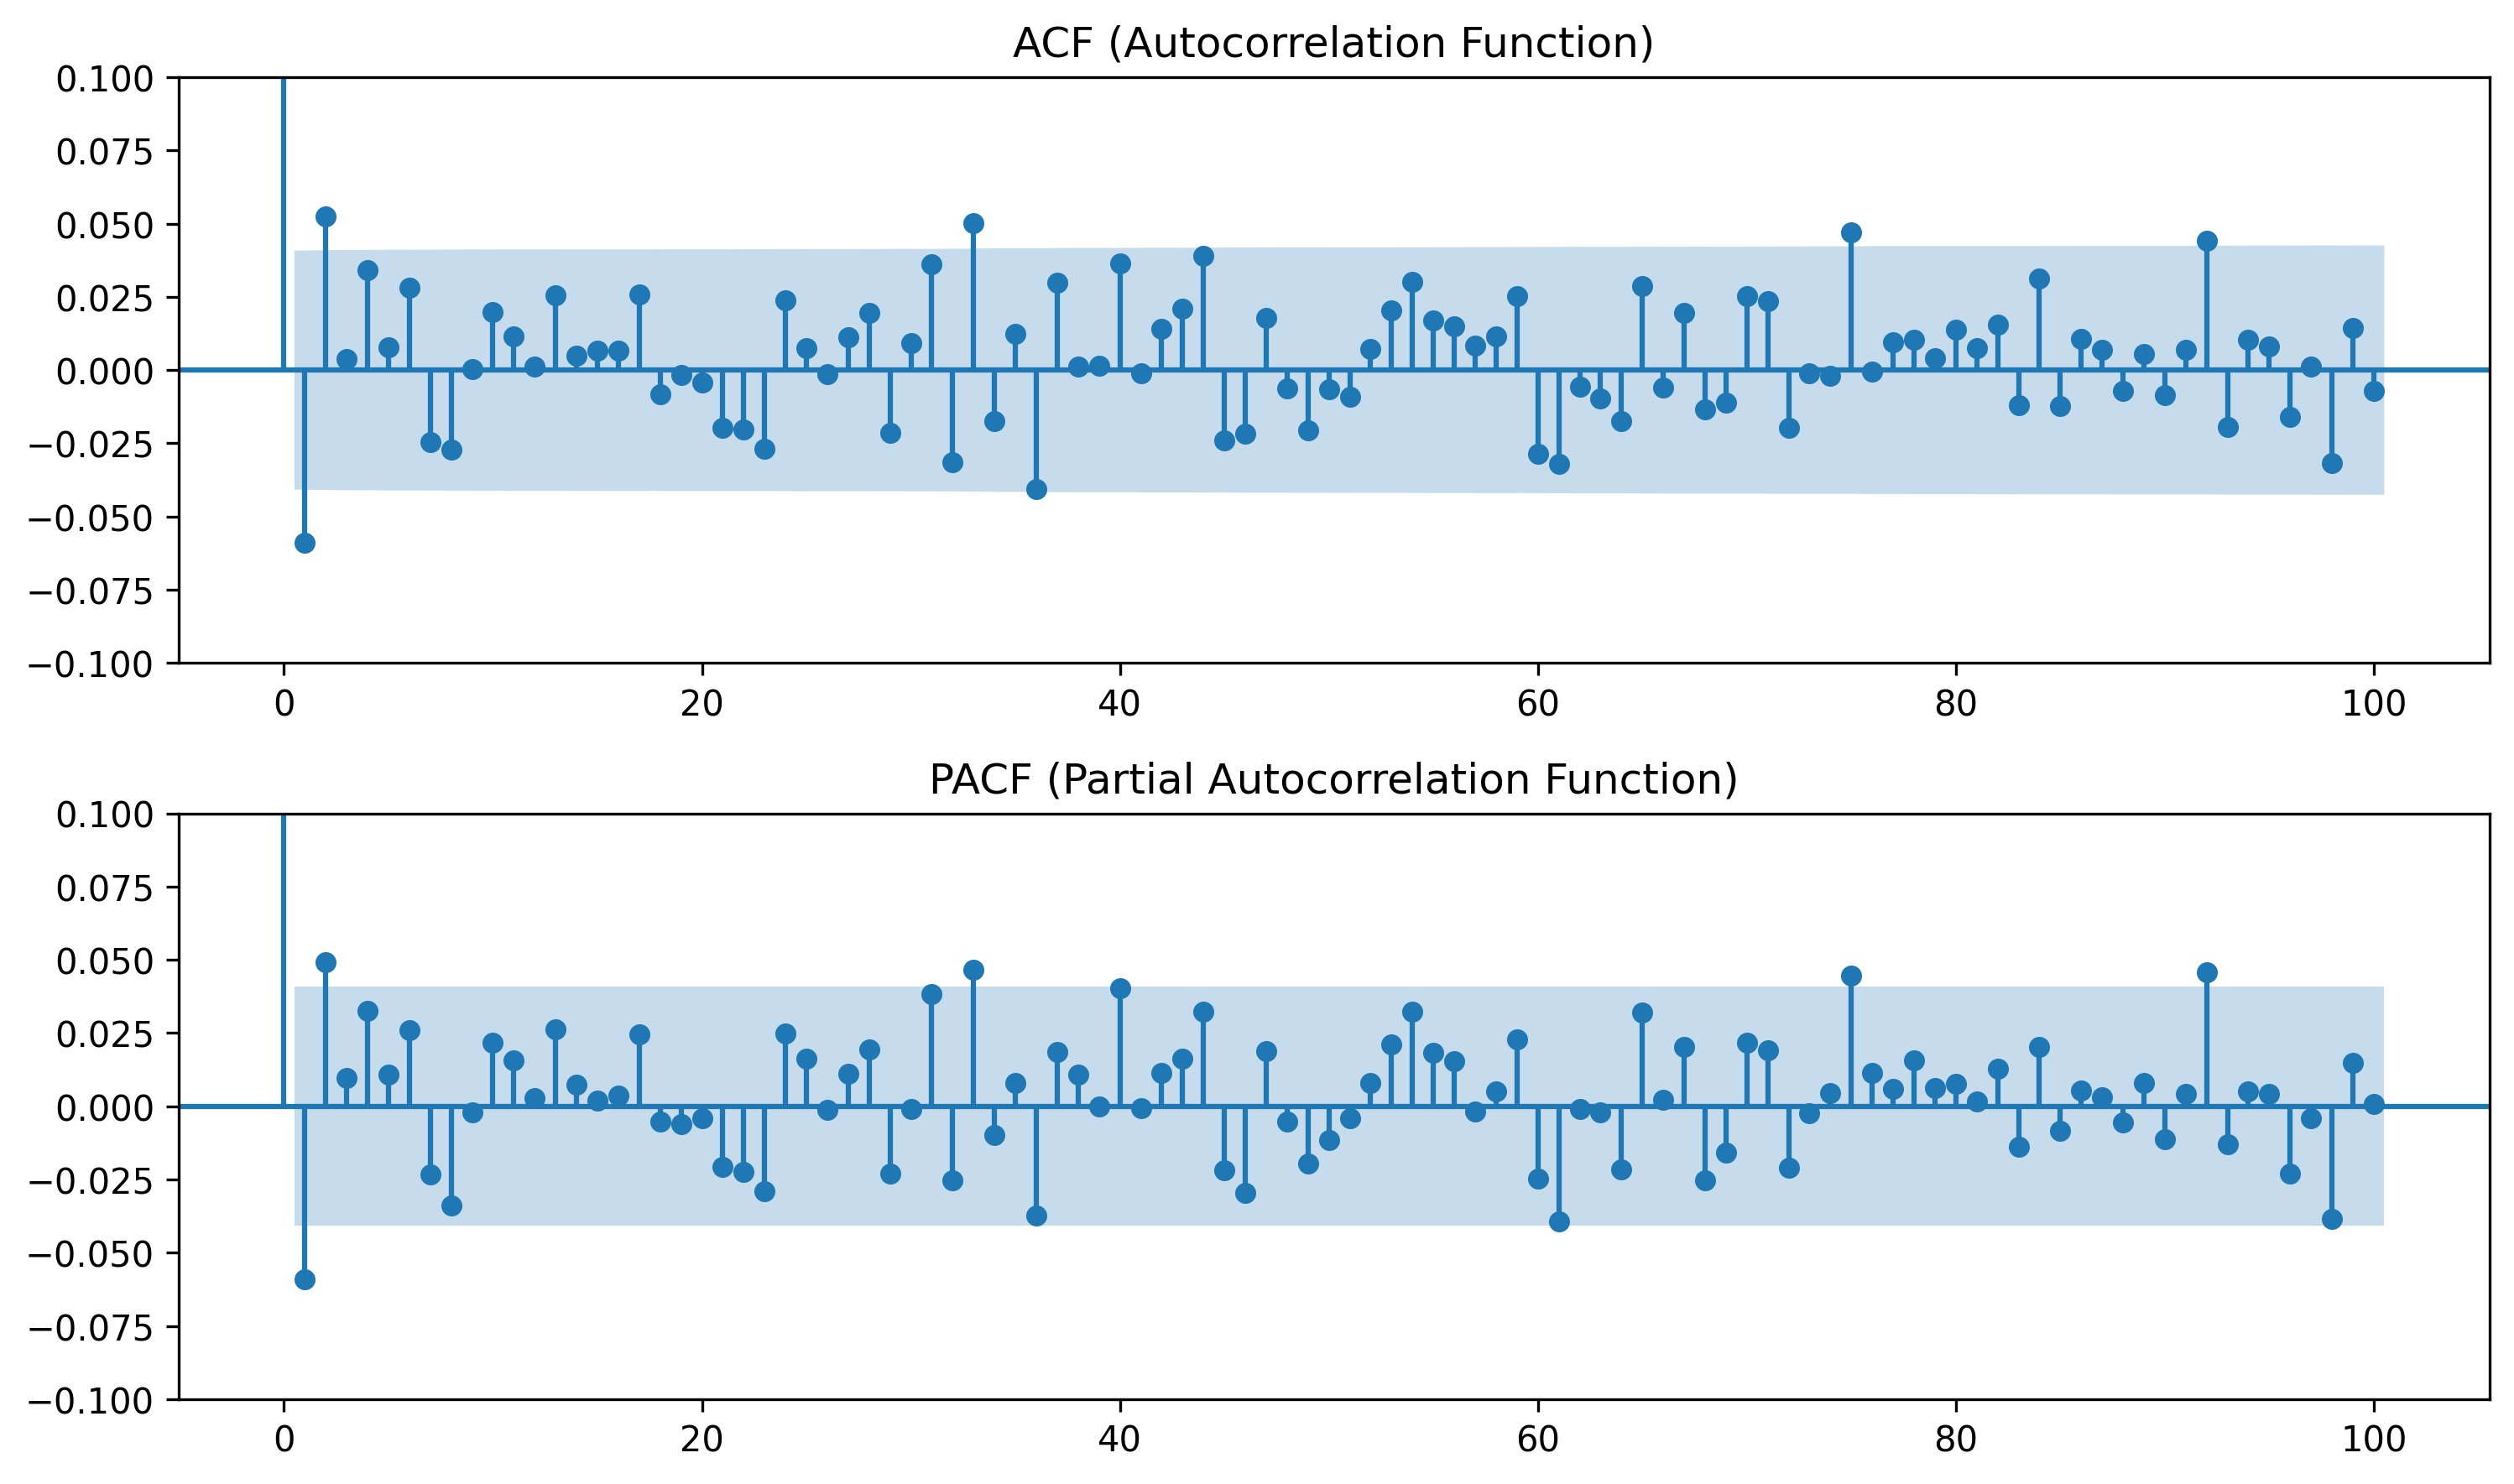

In [331]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), dpi=300)

# Plot ACF
plot_acf(df['Return'], lags=100, ax=ax[0])
ax[0].set_title('ACF (Autocorrelation Function)')
ax[0].set_ylim(-0.1, 0.1)

# Plot PACF
plot_pacf(df['Return'], lags=100, ax=ax[1])
ax[1].set_title('PACF (Partial Autocorrelation Function)')
ax[1].set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()